In [20]:
import pandas as pd
from datetime import datetime
import numpy as np
# from fbprophet import Prophet
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pickle
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from evaluate_forecasts import simple_n_day_ahead_forecast, advanced_n_day_ahead_forecast
from darts import TimeSeries


# Load dataset

In [21]:
ts60 = pd.read_csv('../../RDN/Load Data (2018-2019)/artifacts/load_60min.csv', index_col=0, parse_dates=True)
load60 = ts60['Load'].dropna()
load60.head()


Date
2018-01-01 00:00:00    18555.875064
2018-01-01 01:00:00    18001.483151
2018-01-01 02:00:00    17017.792074
2018-01-01 03:00:00    16187.432017
2018-01-01 04:00:00    15621.660524
Name: Load, dtype: float64

# Config
Steps for day ahead forecasts are preset to 24 (1 day)

In [26]:
steps = 24
days_ahead = 7
last_train_year_id = 2019
last_train_month_id = 12
last_train_day_id = 1
last_train_day = datetime(last_train_year_id, last_train_month_id,
                          last_train_day_id)  # a week finishes there
model_id_date = f'{last_train_year_id}_{last_train_month_id}_{last_train_day_id}'

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (Temp/ipykernel_5456/2251260900.py, line 5)

# Train / Test

In [23]:
scaler_class = StandardScaler()

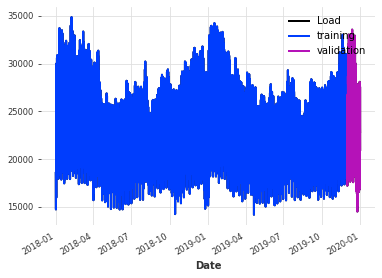

In [29]:
from rdn_train_test_split import rdn_train_test_split
train, test = rdn_train_test_split(load60,
                                   last_train_day,
                                   days_ahead,
                                   steps,
                                   freq='H')
               
# series = TimeSeries.from_series(load60)
# series.plot()
# train, val = series.split_before(pd.Timestamp(
#     f'{last_train_year_id}{last_train_month_id}{str(last_train_day_id) if len(str(last_train_day_id))==2 else str(0)+str(last_train_day_id)}'))
# train.plot(label='training')
# val.plot(label='validation')
# plt.legend()


# Evaluation

## TBATS

### Load model and scaler

In [6]:
tbats = pickle.load(open(f"../../RDN/Load Data (2018-2019)/models/rdn_tbats_{model_id_date}.pkl", "rb"))
scaler = pickle.load(open("../../RDN/Load Data (2018-2019)/models/scaler.pkl", "rb"))


### Day ahead forecasts

Simple 1 day ahead forecast:



<Figure size 432x288 with 0 Axes>

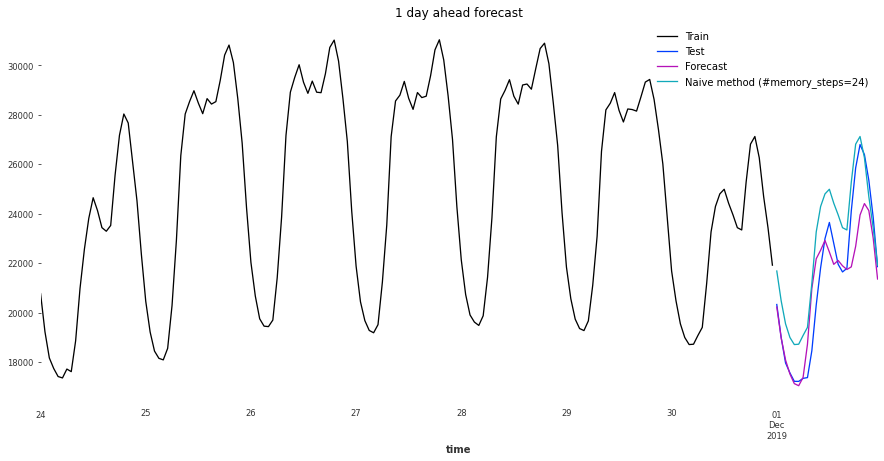

{'MAPE naive': 0.07138076022269556,
 'MAPE': 0.04113152685714583,
 'MSE': 1839600.3759018192,
 'RMSE': 1356.3186852291828}

In [7]:
predictions, metrics = simple_n_day_ahead_forecast(tbats,
                                                   1,
                                                   steps,
                                                   train,
                                                   test,
                                                   scaler,
                                                   naive_remebers_k_timesteps=24)
metrics

## N Day ahead forecast

Simple 7 day ahead forecast:



<Figure size 432x288 with 0 Axes>

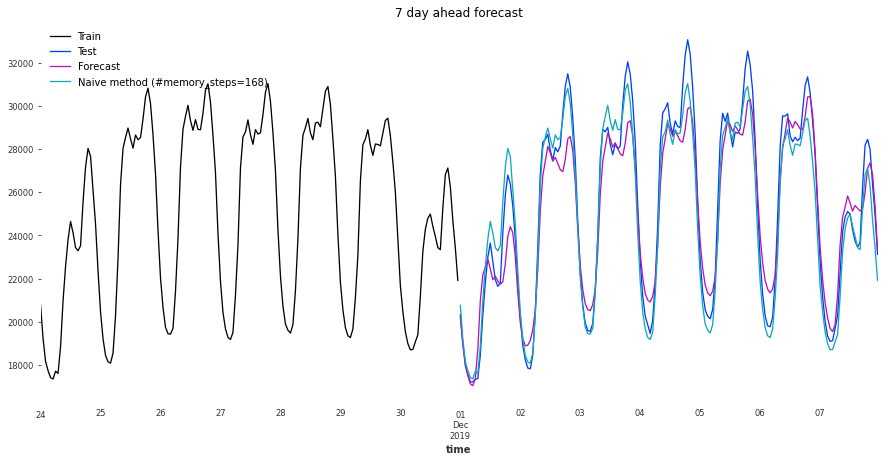

(Date
 2019-12-01 00:00:00    20224.665465
 2019-12-01 01:00:00    18976.906982
 2019-12-01 02:00:00    18082.117575
 2019-12-01 03:00:00    17514.478983
 2019-12-01 04:00:00    17126.121353
                            ...     
 2019-12-07 19:00:00    27107.764355
 2019-12-07 20:00:00    27360.236182
 2019-12-07 21:00:00    26799.603164
 2019-12-07 22:00:00    25342.003905
 2019-12-07 23:00:00    23276.318066
 Freq: H, Length: 168, dtype: float64,
 {'MAPE naive': 0.030242705902769756,
  'MAPE': 0.03941504171145729,
  'MSE': 1658728.499577374,
  'RMSE': 1287.9163402866561})

In [8]:
simple_n_day_ahead_forecast(tbats,
                            days_ahead,
                            steps,
                            train,
                            test,
                            scaler,
                            naive_remebers_k_timesteps=24*days_ahead)

7 day ahead forecast is worst than naive. However we wont need such long forecasts without updates in real life.

## SARIMAX

### Load weather & time variables

In [9]:
# weather = pd.read_csv('../../VEOLIA/artifacts/weather_curated_60min.csv', index_col=0, parse_dates=True)[datetime(2020, 11, 6):]

# time = pd.read_csv('../../VEOLIA/artifacts/time_60min.csv', index_col=1, parse_dates=True)[datetime(2020, 11, 6):]
# time_useful = time[['weekday', 'weekend', 'holiday', 'hour']].astype(int)

# exog_testing = pd.concat((weather.loc[test.index], time_useful.loc[test.index]), axis=1)


In [10]:
time = pd.read_csv('../../RDN/Load Data (2018-2019)/artifacts/time_60min.csv', index_col=1, parse_dates=True)
time_useful = time[['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
                    'hour_sin', 'hour_cos', 'holiday', 'monthday_sin',
                    'monthday_cos', 'yearday_cos', 'yearday_sin']].astype(int)
time_useful.head()


,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,holiday,monthday_sin,monthday_cos,yearday_cos,yearday_sin
datetime,,,,,,,,,,,
2018-01-01 00:00:00,0,1,0,1,0,1,1,0,1,1,0
2018-01-01 01:00:00,0,1,0,1,0,0,1,0,1,1,0
2018-01-01 02:00:00,0,1,0,1,0,0,1,0,1,1,0
2018-01-01 03:00:00,0,1,0,1,0,0,1,0,1,1,0
2018-01-01 04:00:00,0,1,0,1,0,0,1,0,1,1,0


In [11]:
# exog_training = pd.concat((weather.loc[train.index], time_useful.loc[train.index]), axis=1)
# exog_testing = pd.concat((weather.loc[test.index], time_useful.loc[test.index]), axis=1)
# exog_training.head()
exog_training = time_useful.loc[train.index]
exog_testing = time_useful.loc[test.index]


### Load model from disk

In [12]:
def __getnewargs__(self):
    return (tuple(i for i in self.params_complete))

statsmodels.api.tsa.statespace.SARIMAX.__getnewargs__ = __getnewargs__
sarimax = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load(
    f'../../RDN/Load Data (2018-2019)/models/rdn_sarimax_pars_{model_id_date}.pkl')
print(sarimax.summary())

# sarima = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('../../VEOLIA/models/tal_sarima.pkl')
# print(sarima.summary())


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                16776
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 24)   Log Likelihood               18130.273
Date:                                 Wed, 15 Sep 2021   AIC                         -36222.546
Time:                                         16:19:06   BIC                         -36075.748
Sample:                                     01-01-2018   HQIC                        -36174.103
                                          - 11-30-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0364      0.027      1.348      0.178      -0.017       0

#### Day ahead forecast 

Simple 1 day ahead forecast:



<Figure size 432x288 with 0 Axes>

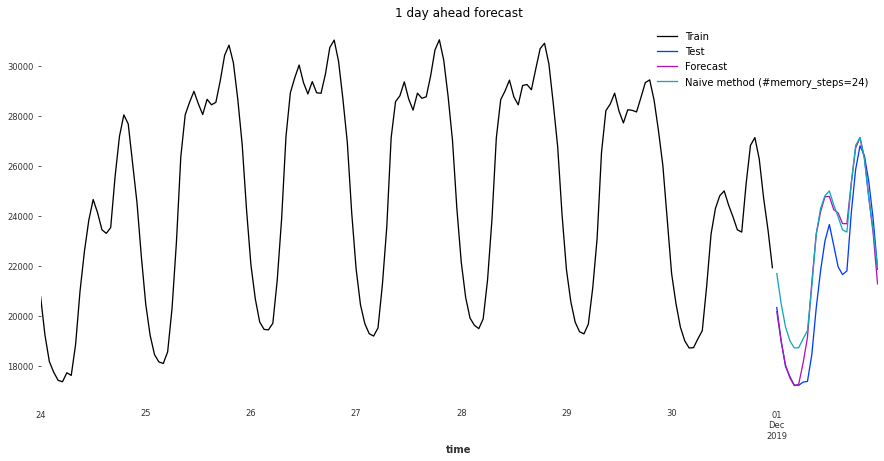

{'MAPE naive': 0.07138076022269556,
 'MAPE': 0.050610034005679184,
 'MSE': 2019418.3729369913,
 'RMSE': 1421.062409937365}

In [13]:
predictions, metrics = simple_n_day_ahead_forecast(sarimax,
                                                   1,
                                                   steps,
                                                   train,
                                                   test,
                                                   scaler,
                                                   exog_test=exog_testing,
                                                   naive_remebers_k_timesteps=24)
metrics


### Simple n-day ahead forecast

Simple 7 day ahead forecast:



<Figure size 432x288 with 0 Axes>

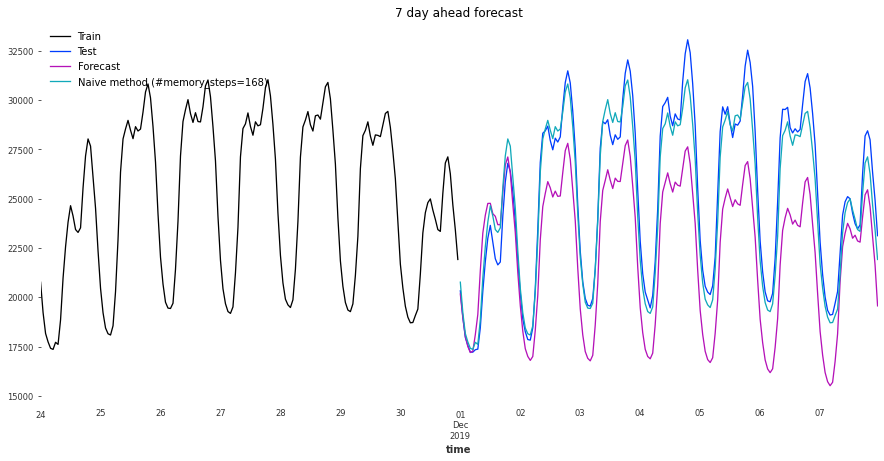

{'MAPE naive': 0.030242705902769756,
 'MAPE': 0.12442889732636327,
 'MSE': 12578469.021682693,
 'RMSE': 3546.6137401305336}

In [14]:
predictions, metrics = simple_n_day_ahead_forecast(sarimax,
                                                   days_ahead,
                                                   steps,
                                                   train,
                                                   test,
                                                   scaler,
                                                   exog_test=exog_testing,
                                                   naive_remebers_k_timesteps=24 * days_ahead)
metrics


## SARIMA

### Load model from disk

In [15]:
def __getnewargs__(self):
    return (tuple(i for i in self.params_complete))

statsmodels.api.tsa.statespace.SARIMAX.__getnewargs__ = __getnewargs__
sarima = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load(
    f'../../RDN/Load Data (2018-2019)/models/rdn_sarima_pars_{model_id_date}.pkl')
print(sarima.summary())


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                16776
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 24)   Log Likelihood               18109.638
Date:                                 Wed, 15 Sep 2021   AIC                         -36203.276
Time:                                         16:19:45   BIC                         -36141.467
Sample:                                     01-01-2018   HQIC                        -36182.879
                                          - 11-30-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9480      0.028     33.981      0.000       0.893       1

#### Day ahead forecast 

Simple 1 day ahead forecast:



<Figure size 432x288 with 0 Axes>

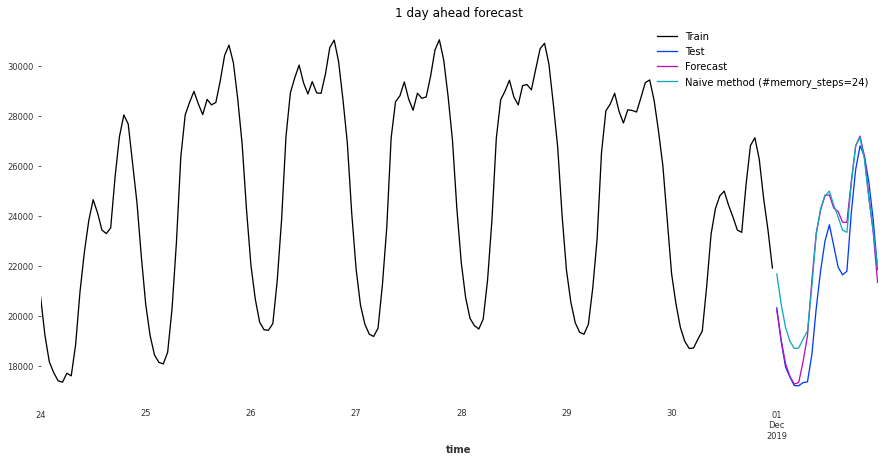

{'MAPE naive': 0.07138076022269556,
 'MAPE': 0.052252951237133416,
 'MSE': 2141362.797103511,
 'RMSE': 1463.339604160125}

In [16]:
predictions, metrics = simple_n_day_ahead_forecast(sarima,
                                                   1, 
                                                   steps,
                                                   train,
                                                   test,
                                                   scaler,
                                                   naive_remebers_k_timesteps=24)
metrics


### Simple n-day ahead forecast

Simple 7 day ahead forecast:



<Figure size 432x288 with 0 Axes>

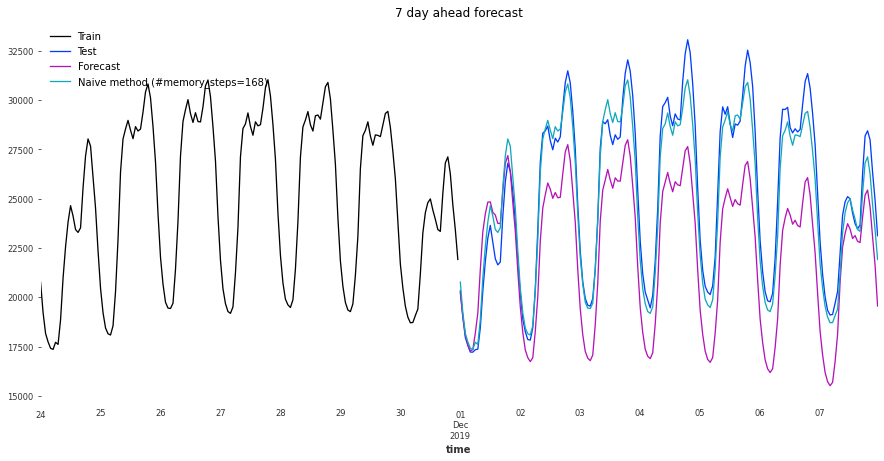

{'MAPE naive': 0.030242705902769756,
 'MAPE': 0.12495773523893253,
 'MSE': 12625839.194162644,
 'RMSE': 3553.2856899161156}

In [17]:
predictions, metrics = simple_n_day_ahead_forecast(sarima,
                                                   days_ahead,
                                                   steps,
                                                   train,
                                                   test,
                                                   scaler,
                                                   naive_remebers_k_timesteps=24 * days_ahead)
metrics


### Advanced 11-day ahead forecast with news update every 24h (no refitting)


In [18]:
predictions, metrics = advanced_n_day_ahead_forecast(sarima,
                                                     days_ahead,
                                                     steps,
                                                     train,
                                                     test,
                                                     scaler)
metrics

Advanced 7 day ahead forecast:



MemoryError: Unable to allocate 726. MiB for an array with shape (16920, 75, 75) and data type float64